# Paper figures 
## A general polarimetric model for transiting and non-transiting ringed exoplanets

This notebook uses `Pryngles` to calculate and generate the figures of the paper:

> A general polarimetric model for transiting and non-transiting ringed exoplanets, Allard. K. Veenstra, Jorge I. Zuluaga, Jaime A. Alvarado-Montes, Mario Sucerquia and Daphne M. Stam (submitted).

## Preliminary

### Required packages

Pryngles pakages and modules:

In [11]:
%load_ext autoreload
%autoreload 2
import pryngles as pr
from pryngles import Consts
extension = 'cpixx'
print(f"Pryngles version: {pr.version}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Pryngles version: 0.9.5


You will need to install the following packages that are not installed with `Pryngles`:

- OpenCV.

If you are in a Linux environmente just run:

In [121]:
!pip install -q opencv-python

Import dependencies

In [122]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cv2 as cv
mpl.rcParams['text.usetex'] = False
plt.rcParams.update({'font.size': 15})

### Configuration

In order to run this scripts is better to have directories for the temporary files and figure files. If you are in Linux use the following cell, otherwise create manually the directories:

In [103]:
!mkdir -p tmp/ figures/

You may change the directory names:

In [101]:
tmp_dir="tmp/"
fig_dir="figures/"

### Get the required data

`Pryngles` has a public Google Drive repo with data useful for calculations. This the repo: https://bit.ly/pryngles-data. You may obtain the data by yourself or retrieve it using the corresponding `Misc` routine. The last one is the more appropiate method since only the name of the file need to be provided:

In [105]:
files=["fou_ring_0_4_0_8.dat","fou_bmsca60.0_asurf1.0.dat"]
pr.Misc.retrieve(files,path=tmp_dir,overwrite=False,quiet=False)

Downloading...
From: https://docs.google.com/feeds/download/spreadsheets/Export?exportFormat=xlsx&key=17rgmzuENn_5jEO2rzDzngJLpZT1P9rPsQr3PNQGFkGs
To: /Users/jorgezuluagacallejas/Dropbox/MiInvestigacion/PapersEnProceso/Exorings/pryngles/doc/papers/full-scattering/tmp/pryngles_files_index.xlsx
31.2kB [00:00, 1.04MB/s]


There are 18 files in data repository.


Downloading...
From: https://docs.google.com/uc?export=download&id=1G_QUlPqyMb0Te3YthH5EqKweSHBJt7MJ
To: /Users/jorgezuluagacallejas/Dropbox/MiInvestigacion/PapersEnProceso/Exorings/pryngles/doc/papers/full-scattering/tmp/fou_ring_0_4_0_8.dat
100%|██████████| 64.9M/64.9M [00:17<00:00, 3.78MB/s]

File tmp//fou_bmsca60.0_asurf1.0.dat already retrieved. For overwrite use overwrite = True.
Files downloaded: ['tmp//fou_ring_0_4_0_8.dat', 'tmp//fou_bmsca60.0_asurf1.0.dat']


['tmp//fou_ring_0_4_0_8.dat', 'tmp//fou_bmsca60.0_asurf1.0.dat']

## Figure 1, planet at different positions in its orbit

The original reference system of `Pryngles` is planet-centered. However, sometimes it is more convenient indicate the orientation of the ring with respect to the observer or the plane of the Sky (see Figure below).
<img src="https://drive.google.com/uc?export=view&id=17PeO_jEK9nSv-E8ZmXxVW-1h8PxsLiS_" width=400>

In [115]:
# Global configuration of the system
gamma = 60.0 # Ring inclinartion, 90 is edge-on, 0 is face-on 
iorb = 70.0 # Orbit inclination, 90 is edge-on, 0 is face-on 
alpha = 0.0 # Ring roll angle 

# Calculate planet-centered conditions
ir, beta_obs, lamb_obs, lamb_star = pr.Util.calcStartingPosition(iorb, gamma, alpha)

print(f"Initial conditions in the planet-centered system are:")
print(f"\tRing inclination w.r.t. ecliptic: {ir*Consts.rad:.1f} deg")
print(f"\tInclination of the observer w.r.t ecliptic: {beta_obs*Consts.rad:.1f} deg")
print(f"\tInitial longitude of the observer: {lamb_obs*Consts.rad:.1f} deg")
print(f"\tInitial longitude of the star: {lamb_star*Consts.rad:.1f} deg")

Initial conditions in the planet-centered system are:
	Ring inclination w.r.t. ecliptic: 10.0 deg
	Inclination of the observer w.r.t ecliptic: 20.0 deg
	Initial longitude of the observer: 90.0 deg
	Initial longitude of the star: -90.0 deg


Create the system

In [116]:
sys = pr.System()

s=sys.add(kind="Star",
          physics=dict(radius=Consts.rsun/sys.ul),
          optics=dict(limb_coeffs=[0.65]))

p=sys.add(kind="Planet", primary=s, 
          radius=Consts.rsaturn/sys.ul,
          orbit=dict(a=1, e=0.0),
          physics=dict(radius=Consts.rsaturn/sys.ul),
          optics=dict(nspangles=10000))

r=sys.add(kind="Ring", primary=p,
          physics=dict(fi=1.2, fe=2.25, i=ir),
          optics=dict(nspangles=10000))

RP=sys.ensamble_system(extension=extension,
                       fname_planet=tmp_dir+'fou_bmsca60.0_asurf1.0.dat',
                       fname_ring=tmp_dir+'fou_ring_0_4_0_8.dat')

Create individual snapshots of the planet around the orbit:

In [117]:
lamb_initial = lamb_star
lamb_final = lamb_initial + 360*Consts.deg
lambs = np.linspace(lamb_initial,lamb_final,9)

# Initialise the starting position
RP.changeObserver([lamb_obs,beta_obs])
RP.changeStellarPosition(lamb_initial)
RP.updateSpangles()

for lamb in lambs:
    RP.changeStellarPosition(lamb)
    RP.updateSpangles()
    RP.updateReflection()

    print(f"Saving snapshots at true anomaly: {(lamb-lamb_initial)*Consts.rad}")
    ecl_fig,obs_fig,star_fig = RP.plotRingedPlanet(showstar=False,showfig=False,showtitle=False,axis=False)
    ecl_fig.savefig(fig_dir + f"fig_at_{int((lamb-lamb_initial)*Consts.rad)}_ecl.png", dpi=500)
    obs_fig.savefig(fig_dir + f"fig_at_{int((lamb-lamb_initial)*Consts.rad)}_obs.png", dpi=500)
    star_fig.savefig(fig_dir + f"fig_at_{int((lamb-lamb_initial)*Consts.rad)}_star.png", dpi=500)
    plt.close()

Saving snapshots at true anomaly: 0.0
Saving snapshots at true anomaly: 45.0
Saving snapshots at true anomaly: 90.0
Saving snapshots at true anomaly: 135.0
Saving snapshots at true anomaly: 180.0
Saving snapshots at true anomaly: 225.0
Saving snapshots at true anomaly: 270.0
Saving snapshots at true anomaly: 315.0
Saving snapshots at true anomaly: 360.0


Now we can compose the configuration image:

In [131]:
def add_subplot_axes(ax,rect,facecolor='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    subax = fig.add_axes([x,y,width,height],facecolor=facecolor)  # matplotlib 2.0+
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax

<IPython.core.display.Javascript object>


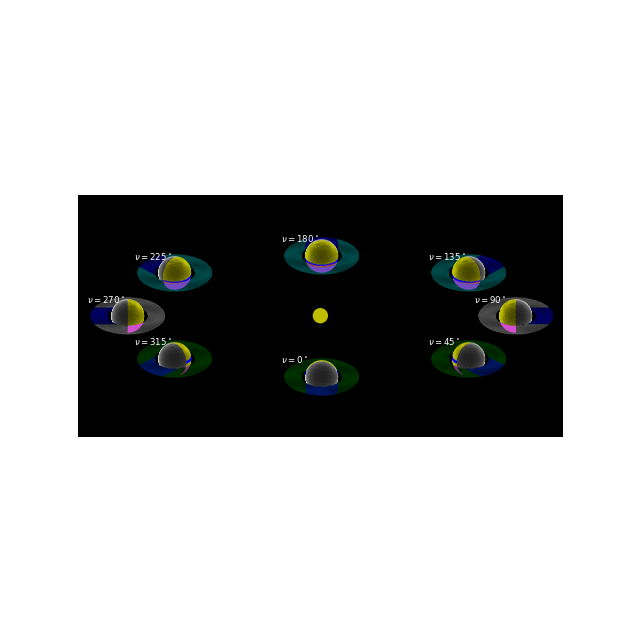

Introducing image 0 corresponging to longitude 0...
Introducing image 1 corresponging to longitude 45...
Introducing image 2 corresponging to longitude 90...
Introducing image 3 corresponging to longitude 135...
Introducing image 4 corresponging to longitude 180...
Introducing image 5 corresponging to longitude 225...
Introducing image 6 corresponging to longitude 270...
Introducing image 7 corresponging to longitude 315...
Saving figure...


In [138]:
def loc_func(phi,a,b):
    x = a*np.cos(phi)+0.5
    y = b*np.sin(phi)+0.5
    return x,y

#Locations
lambs = np.array([0,45,90,135,180,225,270,315])
names=[]
for lamb in lambs:
    names+=[f"$\nu={lamb:d} \degree$"]

# Insert image properties
ratio = np.sin(np.pi/2 - 60*np.pi/180)
xpixels = 5000
ypixels = int(xpixels*ratio)
img = np.zeros((ypixels,xpixels))

# Axis sizes
ysize = 0.4*ratio
xsize = 0.4

# Convert to 3 channel black (color)
img = cv.merge([img,img,img])

# Location of subplot
phi = np.linspace(-np.pi/2,3/2*np.pi,9)
a = 0.5
b = 0.5*ratio
xloc,yloc = loc_func(phi,a,b)

# Offset
eqv75 = 0.75#1-np.sin(45*np.pi/180)/2
eqv25 = 0.25#np.sin(45*np.pi/180)/2

xoffset = np.array([0.5*ysize,eqv75*ysize,ysize,eqv75*ysize,0.5*ysize,
                    eqv25*ysize,0,eqv25*ysize])
yoffset = np.array([xsize,eqv25*xsize,0.5*xsize,eqv75*xsize,0,eqv75*xsize,
                    0.5*xsize,eqv25*xsize])
sub_plot_locx = xloc[:-1]-xoffset
sub_plot_locy = yloc[:-1]-xsize*0.5#yoffset

#Create figure
fsize = 1 # Use 5 for paper purposes
fig = plt.figure(figsize=(5*fsize,5*fsize))
gs = fig.add_gridspec(1)
axs = gs.subplots(sharex=False)
axs.imshow(img)
star = plt.Circle((2500, 2500*(ratio)), 70, color='y')
axs.add_patch(star)

for ii,lamb in enumerate(lambs):
    print(f"Introducing image {ii} corresponging to longitude {lamb}...")
    figure_loc = fig_dir + f"fig_at_{lamb}_obs.png"
    figure = cv.imread(figure_loc)

    subpos = [sub_plot_locx[ii],sub_plot_locy[ii],ysize,xsize]
    subax1 = add_subplot_axes(axs,subpos)

    b, g, r = cv.split(figure)
    tmp = cv.cvtColor(figure, cv.COLOR_BGR2GRAY)
    _,alpha = cv.threshold(tmp,0,255,cv.THRESH_BINARY)
    rgba = [r,g,b, alpha]
    figure_crop = cv.merge(rgba,4)
    scale = 6/9 #5/9
    width = int(figure_crop.shape[1] * scale)
    height = int(figure_crop.shape[0] * scale)
    dim = (width,height)
    resized = cv.resize(figure_crop, dim, interpolation = cv.INTER_AREA)
    subax1.imshow(resized, interpolation='spline36', aspect='auto')
    subax1.text(0.09, 0.67, f"$\\nu={lamb}^\circ$", 
                {'fontsize': 5*fsize}, horizontalalignment='left',
                verticalalignment='center', transform=subax1.transAxes,color="w")
    subax1.set_axis_off()
    
axs.set_axis_off()
print("Saving figure...")
fig.savefig(fig_dir + "Diff_positions_new.png", dpi=600, bbox_inches='tight')
"""
fig.savefig("/home/allard/Results/Diff_positions_new.png", dpi=600, bbox_inches='tight')
fig.savefig("/home/allard/Results/Diff_positions_new.eps", format='eps', bbox_inches='tight')
fig.savefig("/home/allard/Results/Diff_positions_new.svg", bbox_inches='tight', format='svg', dpi=600)
plt.show()
""";